In [1]:
import itertools
import os
import random
import re
from glob import glob
import matplotlib.pyplot as plt
import cv2
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage import zoom
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from sklearn.model_selection import train_test_split
from random import sample
from PIL import Image
import pandas as pd
import optuna
import argparse
import os
from Image_Segmentation.solver import Solver
from Image_Segmentation.data_loader import get_loader
from torch.backends import cudnn
import random

def display_image_and_mask(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.title('Image and Mask')
    plt.axis('off')

    plt.show()



def dataset_init(display_bool= False):
    num_dataset = 1

    image_path_dataset_1= '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images'
    mask_path_dataset_1= '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/masks'

    print(len(os.listdir(image_path_dataset_1)), len(os.listdir(mask_path_dataset_1)))


    if display_bool== True:
        sample_image_1 = os.path.join(image_path_dataset_1, os.listdir(image_path_dataset_1)[0])
        sample_mask_1 = os.path.join(mask_path_dataset_1, os.listdir(mask_path_dataset_1)[0])
        display_image_and_mask(sample_image_1, sample_mask_1)

    image_paths_1 = [os.path.join(image_path_dataset_1, img) for img in os.listdir(image_path_dataset_1)]
    mask_paths_1 = [os.path.join(mask_path_dataset_1, img) for img in os.listdir(mask_path_dataset_1)]


    image_paths = image_paths_1
    mask_paths = mask_paths_1

    image_paths.sort()
    mask_paths.sort()


    paired_paths = list(zip(image_paths, mask_paths))



    return paired_paths

def objective(trial, config):
    paired_paths = dataset_init()
    train_val_paths, test_paths = train_test_split(paired_paths, test_size=0.2, random_state=42)
    train_paths, val_paths = train_test_split(train_val_paths, test_size=0.25, random_state=42)

    # Create directories if not exist
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)
    if not os.path.exists(config.result_path):
        os.makedirs(config.result_path)
    config.result_path = os.path.join(config.result_path, config.model_type)
    if not os.path.exists(config.result_path):
        os.makedirs(config.result_path)

    if trial is not None:
        lr = trial.suggest_float('lr', 0.0000005, 0.0005)
        augmentation_prob = trial.suggest_float('augmentation_prob', 0.0, 0.7)
        epoch = trial.suggest_categorical('epoch', [100]) #100, 150, 200, 250
        decay_ratio = trial.suggest_float('decay_ratio', 0.0, 0.8)
    else:
        lr = config.lr
        augmentation_prob = config.augmentation_prob
        epoch = config.num_epochs
        decay_ratio = config.decay_ratio

    decay_epoch = int(epoch * decay_ratio)

    config.augmentation_prob = augmentation_prob
    config.num_epochs = epoch
    config.lr = lr
    config.num_epochs_decay = decay_epoch

    print(config)

    if config.mode == 'indivi_test' or 'indivi_test_dataset' or 'eval_test':
        config.batch_size = 1

    train_loader = get_loader(image_mask_pairs=train_paths,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='train',
                            augmentation_prob=config.augmentation_prob)
    valid_loader = get_loader(image_mask_pairs=val_paths,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='valid',
                            augmentation_prob=0.)
    test_loader = get_loader(image_mask_pairs=test_paths,
                            image_size=config.image_size,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers,
                            mode='test',
                            augmentation_prob=0.)
    
    # Train and sample the images
    if config.mode == 'train':
        solver = Solver(config, train_loader, valid_loader, test_loader)
        DC = solver.train()
    if config.mode == 'eval_test':
        solver = Solver(config, train_loader, valid_loader, test_loader, config.test_model_path)
        solver.eval_test(top_k= 4)
        DC = None
    if config.mode == 'indivi_test':
        solver = Solver(config,  model_path_eval = config.test_model_path)
        solver.eval_image(image_path = config.image_path)
        DC = None


    return DC

def main(config):
    if config.tune:
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, config), n_trials=50)
        
        print('Number of finished trials: ', len(study.trials))
        print('Best trial:')
        trial = study.best_trial
        print('  Value: ', trial.value)
        print('  Params: ')
        for key, value in trial.params.items():
            print(f'    {key}: {value}')
    else:
        objective(None, config)





1000 1000


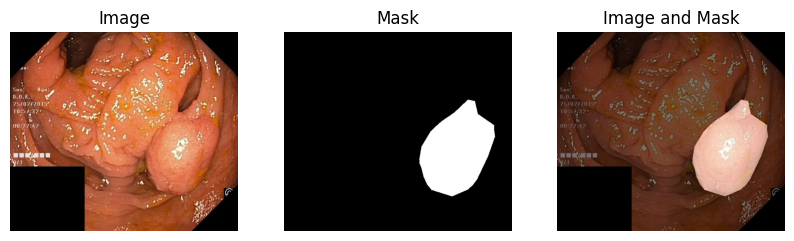

[('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg',
  '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg'),
 ('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg',
  '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/masks/cju0qoxqj9q6s0835b43399p4.jpg'),
 ('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg',
  '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/masks/cju0qx73cjw570799j4n5cjze.jpg'),
 ('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju0roawvklrq0799vmjorwfv.jpg',
  '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/masks/cju0roawvklrq0799vmjorwfv.jpg'),
 ('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju0rx1idathl0835detmsp84.jpg',
  '../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/masks/cju0rx1idathl0835detmsp84.jpg'),
 ('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju0s2a9ekvms080138tjjpxr.jpg',
  '../data/kvasir-dataset/kvasir-seg/Kvasir

In [2]:
dataset_init(display_bool= True)

TRAINNING U_Net/R2U_Net/AttU_Net/R2AttU_Net

In [3]:
### TRAINNING U_Net
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # model hyper-parameters
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net')

    # training hyper-parameters
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=150)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam    
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--decay_ratio', type=float, default=0.5)  # Default decay ratio

    parser.add_argument('--log_step', type=int, default=2)
    parser.add_argument('--val_step', type=int, default=2)

    # misc
    parser.add_argument('--mode', type=str, default='train')
    parser.add_argument('--model_type', type=str, default='U_Net', help='U_Net/R2U_Net/AttU_Net/R2AttU_Net')
    parser.add_argument('--model_path', type=str, default='../Output/models')
    parser.add_argument('--test_model_path', type=str, default='//home/mlam/Documents/BME_NN_course/Output/models/R2AttU_Net-200-0.0005-137-0.6380.pkl')
    parser.add_argument('--image_path', type=str, default='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg')
    parser.add_argument('--result_path', type=str, default='../Output/result/')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--tune', action='store_true', default=False, help='Flag to enable hyperparameter tuning with Optuna')

    args, unknown = parser.parse_known_args()  # This will parse known args and ignore the unknown ones

    main(args)

1000 1000
Namespace(image_size=224, t=3, img_ch=3, output_ch=1, num_epochs=150, num_epochs_decay=75, batch_size=2, num_workers=4, lr=0.0002, beta1=0.5, beta2=0.999, augmentation_prob=0.4, decay_ratio=0.5, log_step=2, val_step=2, mode='train', model_type='U_Net', model_path='../Output/models', test_model_path='//home/mlam/Documents/BME_NN_course/Output/models/R2AttU_Net-200-0.0005-137-0.6380.pkl', image_path='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg', result_path='../Output/result/U_Net', cuda_idx=1, tune=False)
image count in train path :600
image count in valid path :200
image count in test path :200
Epoch [1/150], Loss: 249.8395, 
[Training] Acc: 0.8328, SE: 0.0390, SP: 0.9925, PC: 0.2259, F1: 0.0512, JS: 0.0316, DC: 0.0512
[Validation] Acc: 0.8723, SE: 0.0119, SP: 0.9966, PC: 0.1836, F1: 0.0187, JS: 0.0107, DC: 0.0187
Best U_Net model score : 0.0294
Epoch [2/150], Loss: 224.4115, 
[Training] Acc: 0.8331, SE: 0.

In [4]:
### TRAINNING R2U_Net
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # model hyper-parameters
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net')

    # training hyper-parameters
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=150)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam    
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--decay_ratio', type=float, default=0.5)  # Default decay ratio

    parser.add_argument('--log_step', type=int, default=2)
    parser.add_argument('--val_step', type=int, default=2)

    # misc
    parser.add_argument('--mode', type=str, default='train')
    parser.add_argument('--model_type', type=str, default='R2U_Net', help='U_Net/R2U_Net/AttU_Net/R2AttU_Net')
    parser.add_argument('--model_path', type=str, default='../Output/models')
    parser.add_argument('--test_model_path', type=str, default='//home/mlam/Documents/BME_NN_course/Output/models/R2AttU_Net-200-0.0005-137-0.6380.pkl')
    parser.add_argument('--image_path', type=str, default='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg')
    parser.add_argument('--result_path', type=str, default='../Output/result/')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--tune', action='store_true', default=False, help='Flag to enable hyperparameter tuning with Optuna')

    args, unknown = parser.parse_known_args()  # This will parse known args and ignore the unknown ones

    main(args)

1000 1000
Namespace(image_size=224, t=3, img_ch=3, output_ch=1, num_epochs=150, num_epochs_decay=75, batch_size=2, num_workers=4, lr=0.0002, beta1=0.5, beta2=0.999, augmentation_prob=0.4, decay_ratio=0.5, log_step=2, val_step=2, mode='train', model_type='R2U_Net', model_path='../Output/models', test_model_path='//home/mlam/Documents/BME_NN_course/Output/models/R2AttU_Net-200-0.0005-137-0.6380.pkl', image_path='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg', result_path='../Output/result/R2U_Net', cuda_idx=1, tune=False)
image count in train path :600
image count in valid path :200
image count in test path :200
Epoch [1/150], Loss: 237.5208, 
[Training] Acc: 0.8328, SE: 0.0149, SP: 0.9974, PC: 0.1650, F1: 0.0210, JS: 0.0130, DC: 0.0210
[Validation] Acc: 0.8729, SE: 0.0000, SP: 1.0000, PC: 0.0050, F1: 0.0000, JS: 0.0000, DC: 0.0000
Best R2U_Net model score : 0.0000
Epoch [2/150], Loss: 230.1268, 
[Training] Acc: 0.8342, 

In [5]:
### TRAINNING AttU_Net
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # model hyper-parameters
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net')

    # training hyper-parameters
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=150)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam    
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--decay_ratio', type=float, default=0.5)  # Default decay ratio

    parser.add_argument('--log_step', type=int, default=2)
    parser.add_argument('--val_step', type=int, default=2)

    # misc
    parser.add_argument('--mode', type=str, default='train')
    parser.add_argument('--model_type', type=str, default='AttU_Net', help='U_Net/R2U_Net/AttU_Net/R2AttU_Net')
    parser.add_argument('--model_path', type=str, default='../Output/models')
    parser.add_argument('--test_model_path', type=str, default='//home/mlam/Documents/BME_NN_course/Output/models/R2AttU_Net-200-0.0005-137-0.6380.pkl')
    parser.add_argument('--image_path', type=str, default='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg')
    parser.add_argument('--result_path', type=str, default='../Output/result/')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--tune', action='store_true', default=False, help='Flag to enable hyperparameter tuning with Optuna')

    args, unknown = parser.parse_known_args()  # This will parse known args and ignore the unknown ones

    main(args)

1000 1000
Namespace(image_size=224, t=3, img_ch=3, output_ch=1, num_epochs=150, num_epochs_decay=75, batch_size=2, num_workers=4, lr=0.0002, beta1=0.5, beta2=0.999, augmentation_prob=0.4, decay_ratio=0.5, log_step=2, val_step=2, mode='train', model_type='AttU_Net', model_path='../Output/models', test_model_path='//home/mlam/Documents/BME_NN_course/Output/models/R2AttU_Net-200-0.0005-137-0.6380.pkl', image_path='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg', result_path='../Output/result/AttU_Net', cuda_idx=1, tune=False)
image count in train path :600
image count in valid path :200
image count in test path :200
Epoch [1/150], Loss: 251.7318, 
[Training] Acc: 0.8301, SE: 0.0467, SP: 0.9892, PC: 0.3109, F1: 0.0577, JS: 0.0359, DC: 0.0577
[Validation] Acc: 0.8243, SE: 0.4354, SP: 0.8874, PC: 0.3764, F1: 0.3111, JS: 0.2193, DC: 0.3111
Best AttU_Net model score : 0.5304
Epoch [2/150], Loss: 226.1567, 
[Training] Acc: 0.836

EVALUATION the best model

1000 1000
Namespace(image_size=224, t=3, img_ch=3, output_ch=1, num_epochs=150, num_epochs_decay=75, batch_size=2, num_workers=4, lr=0.0002, beta1=0.5, beta2=0.999, augmentation_prob=0.4, decay_ratio=0.5, log_step=2, val_step=2, mode='eval_test', model_type='AttU_Net', model_path='../Output/models', test_model_path='/home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl', image_path='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg', result_path='../Output/result/AttU_Net', cuda_idx=1, tune=False)
image count in train path :600
image count in valid path :200
image count in test path :200
/home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl
AttU_Net is Successfully Loaded from /home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl
1 ('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju5ufn3skquf0818dhapnhba.jpg',) Accuracy: 0.99441964

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


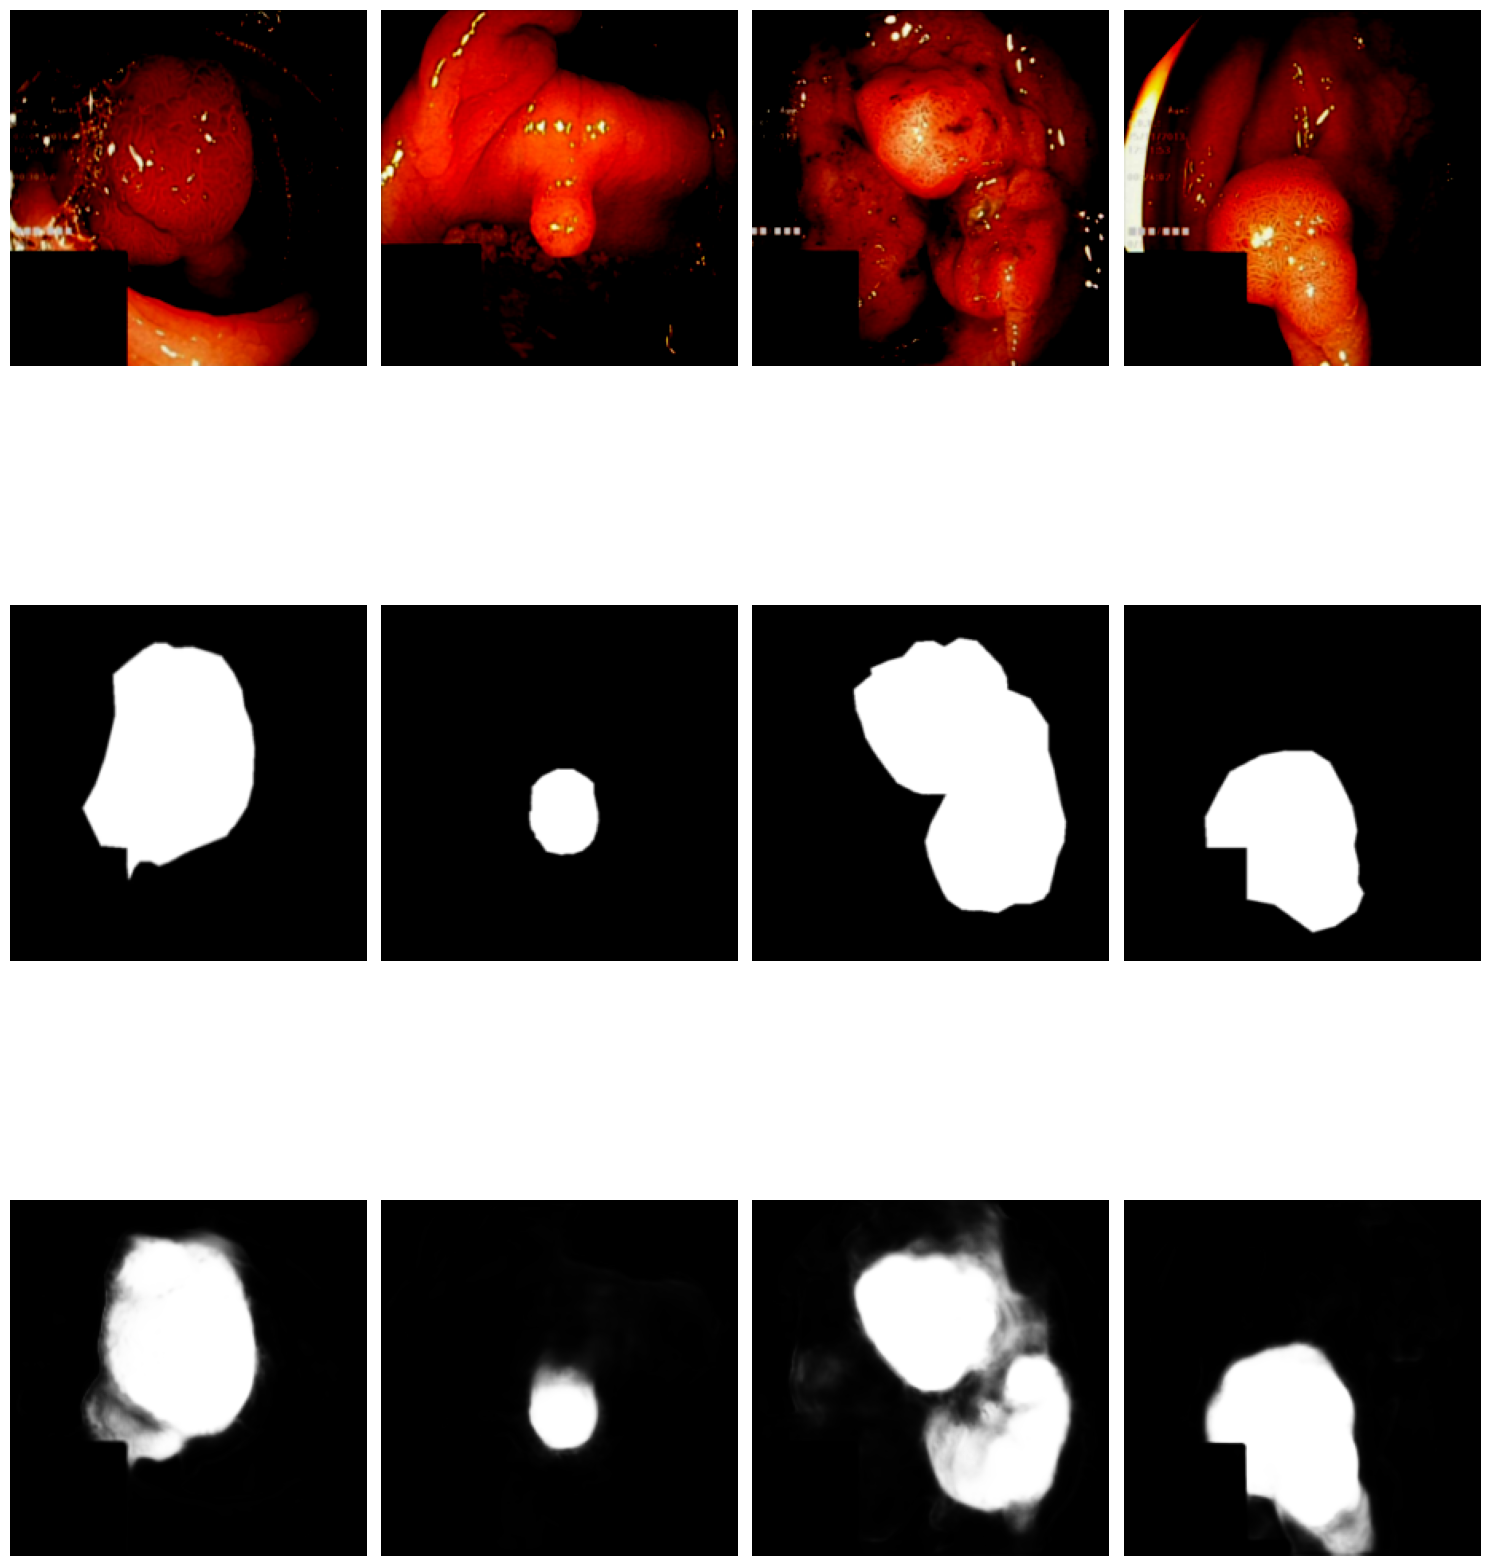

('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju34c1xfyz920993itxkkfad.jpg',) 0.6377100247533593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju2zpw4q9vzr0801p0lysjdl.jpg',) 0.6375663753044698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cju3ykamdj9u208503pygyuc8.jpg',) 0.6293041673387799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('../data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/cjyzjzssvd8pq0838f4nolj5l.jpg',) 0.6144444236778305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


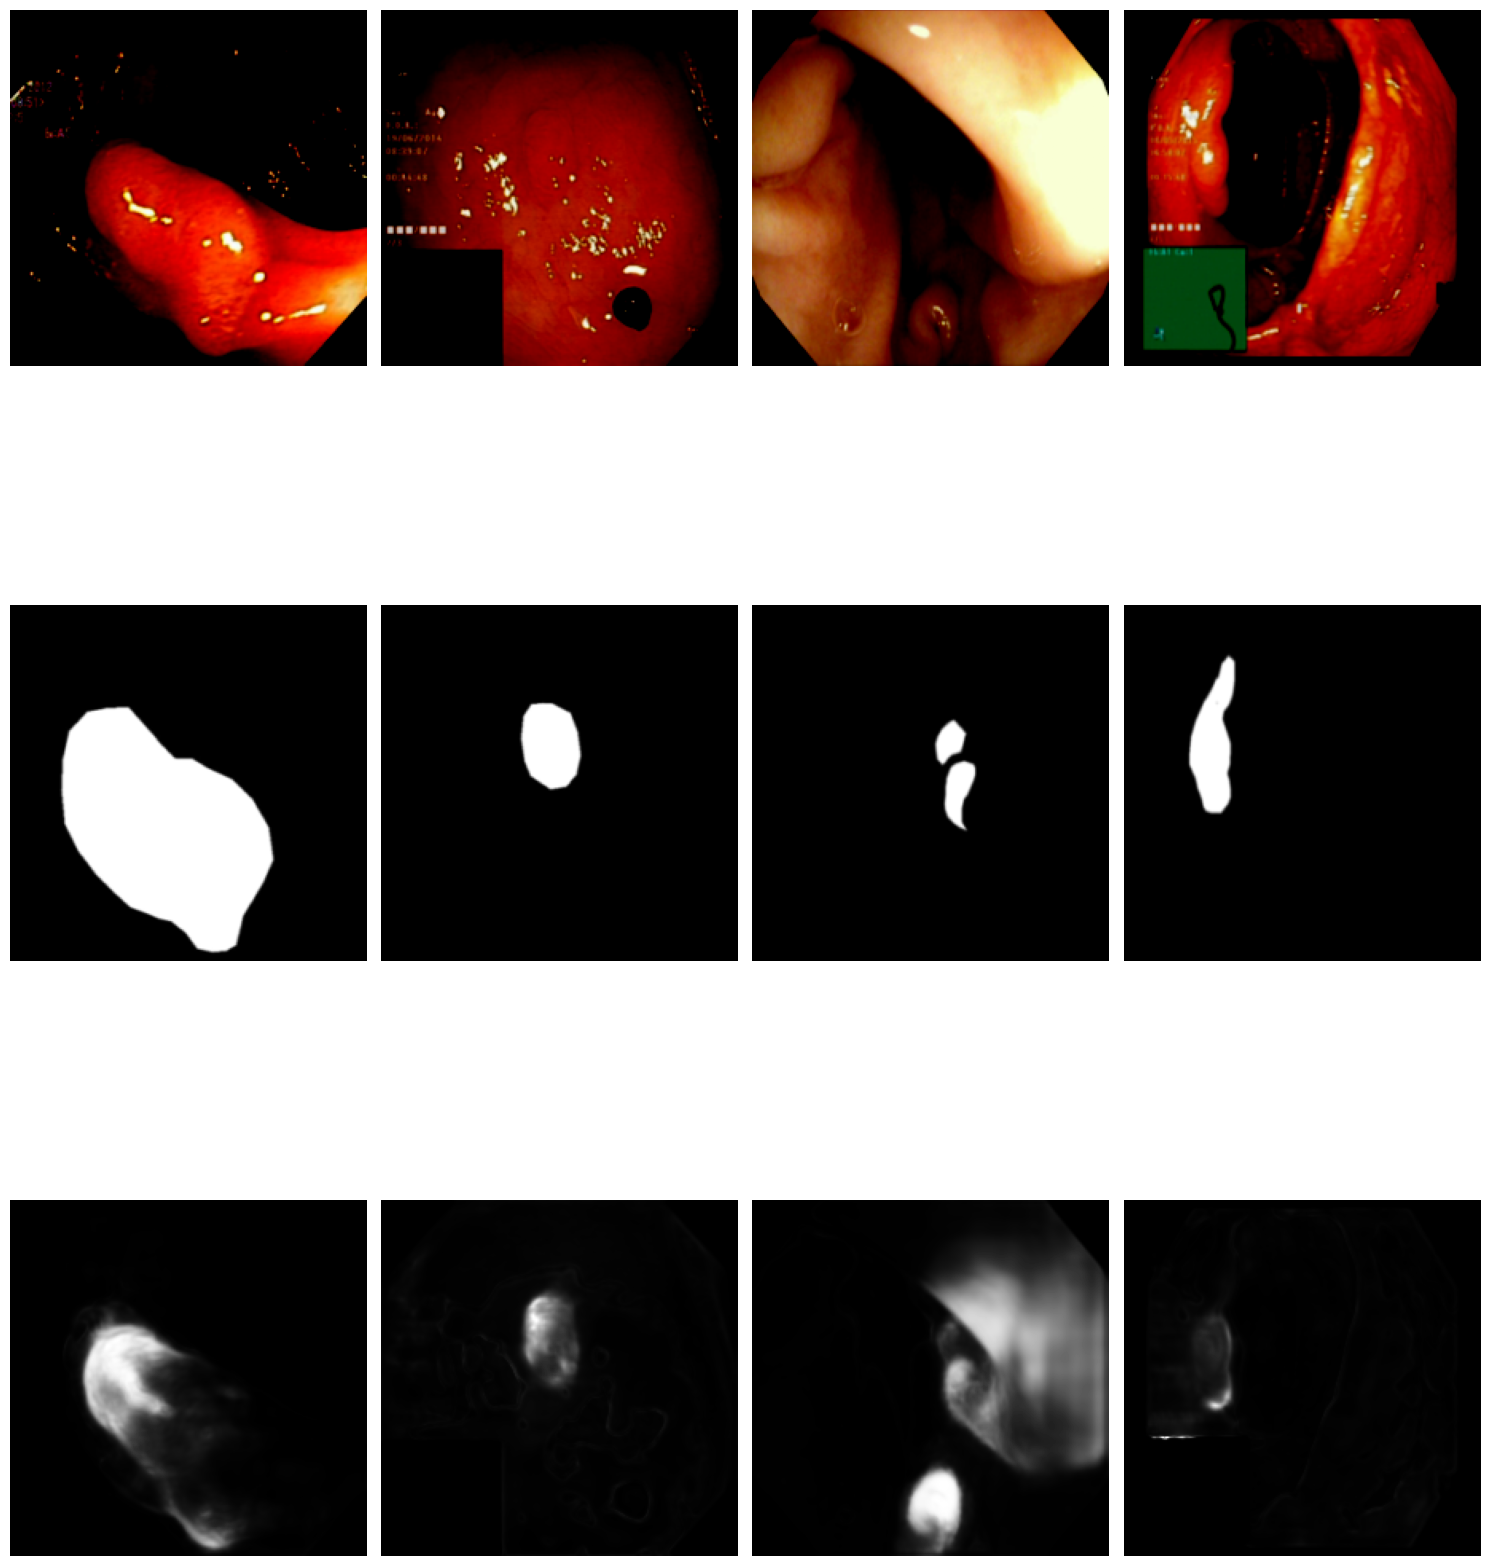

In [9]:
###  EVALUATION TEST SET
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # model hyper-parameters
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net')

    # training hyper-parameters
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=150)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam    
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--decay_ratio', type=float, default=0.5)  # Default decay ratio

    parser.add_argument('--log_step', type=int, default=2)
    parser.add_argument('--val_step', type=int, default=2)

    # misc
    parser.add_argument('--mode', type=str, default='eval_test')
    parser.add_argument('--model_type', type=str, default='AttU_Net', help='U_Net/R2U_Net/AttU_Net/R2AttU_Net')
    parser.add_argument('--model_path', type=str, default='../Output/models')
    parser.add_argument('--test_model_path', type=str, default='/home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl')
    parser.add_argument('--image_path', type=str, default='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg')
    parser.add_argument('--result_path', type=str, default='../Output/result/')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--tune', action='store_true', default=False, help='Flag to enable hyperparameter tuning with Optuna')

    args, unknown = parser.parse_known_args()  # This will parse known args and ignore the unknown ones

    main(args)

1000 1000
Namespace(image_size=224, t=3, img_ch=3, output_ch=1, num_epochs=150, num_epochs_decay=75, batch_size=2, num_workers=4, lr=0.0002, beta1=0.5, beta2=0.999, augmentation_prob=0.4, decay_ratio=0.5, log_step=2, val_step=2, mode='indivi_test', model_type='AttU_Net', model_path='../Output/models', test_model_path='/home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl', image_path='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg', result_path='../Output/result/AttU_Net', cuda_idx=1, tune=False)
image count in train path :600
image count in valid path :200
image count in test path :200
/home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl
AttU_Net is Successfully Loaded from /home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl
torch.Size([1, 1, 224, 256])


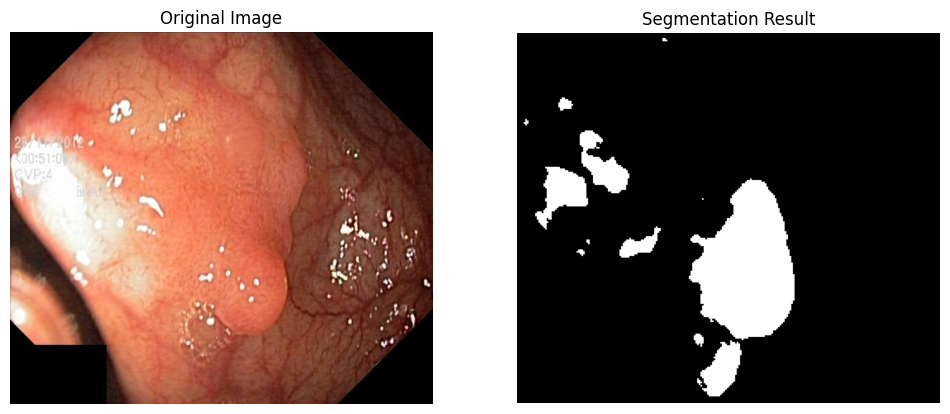

In [8]:
###  EVALUATION CERTAIN IMAGE
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # model hyper-parameters
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net')

    # training hyper-parameters
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=150)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam    
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--decay_ratio', type=float, default=0.5)  # Default decay ratio

    parser.add_argument('--log_step', type=int, default=2)
    parser.add_argument('--val_step', type=int, default=2)

    # misc
    parser.add_argument('--mode', type=str, default='indivi_test')
    parser.add_argument('--model_type', type=str, default='AttU_Net', help='U_Net/R2U_Net/AttU_Net/R2AttU_Net')
    parser.add_argument('--model_path', type=str, default='../Output/models')
    parser.add_argument('--test_model_path', type=str, default='/home/mlam/Documents/BME_NN_course/Output/models/AttU_Net-150-0.0002-75-0.4000.pkl')
    parser.add_argument('--image_path', type=str, default='/home/mlam/Documents/BME_NN_course/data/kvasir-dataset/kvasir-seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg')
    parser.add_argument('--result_path', type=str, default='../Output/result/')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--tune', action='store_true', default=False, help='Flag to enable hyperparameter tuning with Optuna')

    args, unknown = parser.parse_known_args()  # This will parse known args and ignore the unknown ones

    main(args)